## Animal Classifier
Training an image classification using pytorch

In [39]:
import os
from pathlib import Path

import torch, torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

print(f"Pytorch version: {torch.__version__}")

Pytorch version: 2.1.1


### SETUP

In [40]:
# GPU or CPU?
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### DATASET
Load and clean the dataset:
1. Make sure the animals dataset is downloaded into the "datasets/animals" directory
   (https://www.kaggle.com/datasets/npurav/animal-classification-dataset)
2. Add augmented images to the dataset.
3. Load the dataset then split into train and test data

In [41]:
# Get root directory
BASE_DIR = Path.cwd().resolve().parent.parent

# Path to your dataset
dataset_path = BASE_DIR / 'datasets/animals/dataset'

# Define transformations (you can customize these based on your needs)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),
])

# Create ImageFolder dataset
dataset = ImageFolder(dataset_path, transform=transform)
class_names = dataset.classes

In [42]:
# Image augmentation
# Define image transformations for augmentation
augmentation_transform = transforms.Compose([
    #transforms.RandomResizedCrop(224),        # Random crop and resize
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomVerticalFlip(),          # Random vertical flip
    # transforms.RandomRotation(degrees=15),    # Random rotation (up to 15 degrees)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomGrayscale(p=0.1),        # Randomly convert to grayscale
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),  # Random perspective
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Create augmented dataset
for i in range(9):
    # Apply augmentation to the entire dataset
    augmented_dataset = ImageFolder(dataset_path, transform=augmentation_transform)
    # Combine the original and augmented datasets
    dataset = torch.utils.data.ConcatDataset([dataset, augmented_dataset])
    
print(f'Total number of images: {len(dataset)}')

Total number of images: 206240


In [43]:
# Split the dataset into training and testing sets

# Define the sizes for training, validation, and testing sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split
trainset, valset, testset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print(f'Total number of training images: {len(trainset)}')
print(f'Total number of validation images: {len(valset)}')
print(f'Total number of test images: {len(testset)}')

Total number of training images: 164992
Total number of validation images: 20624
Total number of test images: 20624


In [44]:
# Create data loaders
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

Display a subset of the training images

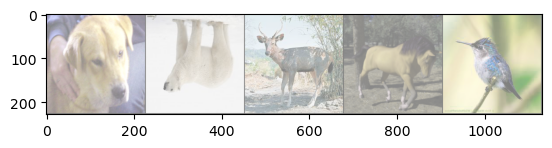

canis-lupus-familiaris ursus-maritimus rusa-unicolor equus-caballus mellisuga-helenae
CPU times: user 661 ms, sys: 284 ms, total: 945 ms
Wall time: 18.5 s


In [45]:
%%time

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[0:5]))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(5)))

### TRAINING STEP
Define a convolution neural network

In [46]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(6, 20, 5)
        self.conv3 = nn.Conv2d(20, 32, 5)
        # self.fc1 = nn.Linear(89888, 400)
        # self.fc1 = nn.Linear(16928, 300)
        self.fc1 = nn.Linear(1152, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, len(class_names))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)
print(f'Trainable params: {sum(p.numel() for p in net.parameters() if p.requires_grad)}')

Trainable params: 455959


Define learning rate, loss function and optimizer

In [47]:
learning_rate = 0.007

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)

Train the network

In [48]:
%%time
epochs = 45

# Initialize an empty list to store loss values for plotting
loss_values = []
val_loss_values = []
print('Starting Training...')
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        step = 200
        if i % step == step - 1:    # print after ever "step" mini-batches
            print(f'epoch({epoch + 1}/{epochs}) batch: {i + 1} loss: {running_loss / step:.3f}')
            # Append the average loss to the list for plotting
            loss_values.append(running_loss / step)
            running_loss = 0.0

    # Calculate validation loss after each epoch
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in valloader:
            val_inputs, val_labels = data[0].to(device), data[1].to(device)
            val_outputs = net(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
    val_loss_values.append(val_running_loss / len(valloader))
    print(f'epoch({epoch + 1}/{epochs}) Validation loss: {val_running_loss / len(valloader)}')

print('Finished Training')

Starting Training...
epoch(1/45) batch: 200 loss: 4.373
epoch(1/45) batch: 400 loss: 4.107
epoch(1/45) batch: 600 loss: 4.054
epoch(1/45) batch: 800 loss: 4.046
epoch(1/45) batch: 1000 loss: 3.914
epoch(1/45) batch: 1200 loss: 3.812
epoch(1/45) batch: 1400 loss: 3.649
epoch(1/45) batch: 1600 loss: 3.543
epoch(1/45) batch: 1800 loss: 3.434
epoch(1/45) batch: 2000 loss: 3.351
epoch(1/45) batch: 2200 loss: 3.248
epoch(1/45) batch: 2400 loss: 3.170
epoch(1/45) Validation loss: 3.183871772636201
epoch(2/45) batch: 200 loss: 3.020
epoch(2/45) batch: 400 loss: 2.978
epoch(2/45) batch: 600 loss: 2.862
epoch(2/45) batch: 800 loss: 2.829
epoch(2/45) batch: 1000 loss: 2.758
epoch(2/45) batch: 1200 loss: 2.688
epoch(2/45) batch: 1400 loss: 2.661
epoch(2/45) batch: 1600 loss: 2.603
epoch(2/45) batch: 1800 loss: 2.534
epoch(2/45) batch: 2000 loss: 2.501
epoch(2/45) batch: 2200 loss: 2.422
epoch(2/45) batch: 2400 loss: 2.385
epoch(2/45) Validation loss: 2.3990009930849814
epoch(3/45) batch: 200 loss:

In [49]:
PATH = BASE_DIR / 'models/ac_py.pth'
torch.save(net.state_dict(), PATH)

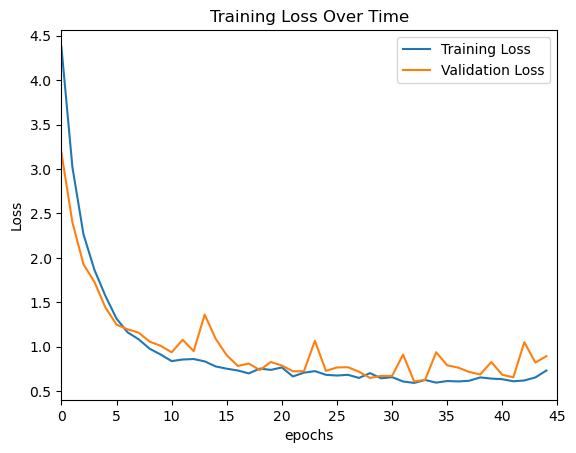

In [51]:
# Plot the loss graph
train_loss_values = []
for i in range(len(loss_values)):
    if i % 12 == 0:
        train_loss_values.append(loss_values[i])
        
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
custom_x_range = (0, epochs)
plt.xlim(custom_x_range)
plt.show()

### TESTING
Test the trained network on test data

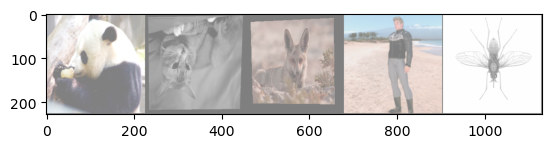

GroundTruth:  ailuropoda-melanoleuca felis-catus vulpes-vulpes homo-sapiens musca-domestica
CPU times: user 769 ms, sys: 207 ms, total: 976 ms
Wall time: 23.4 s


In [52]:
%%time

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[0:5]))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(5)))

In [53]:
# Load the trained model
PATH = BASE_DIR / 'models/ac_py.pth'

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Run tests on a subset of test data

In [54]:
%%time
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}' for j in range(5)))

Predicted:  ailuropoda-melanoleuca ailuropoda-melanoleuca canis-lupus homo-sapiens musca-domestica
CPU times: user 1.07 s, sys: 192 ms, total: 1.26 s
Wall time: 166 ms


Run test on the entire test data

In [55]:
%%time
# Find the test loss
test_running_loss = 0.0
with torch.no_grad():
    for data in testloader:
        test_inputs, test_labels = data
        
        test_outputs = net(test_inputs)
        test_loss = criterion(test_outputs, test_labels)
        test_running_loss += test_loss.item()
print(f'Test Loss: {test_running_loss / len(testloader)}')

Test Loss: 0.8889587738381082
CPU times: user 1min 5s, sys: 11 s, total: 1min 16s
Wall time: 1min 36s


In [56]:
%%time
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        if inputs.size()[0] != batch_size:
            break
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Number of test images: {total}')
print(f'Number of correct predictions: {correct}')
print(f'Accuracy of the network on test images: {100 * correct // total} %')

Number of test images: 20608
Number of correct predictions: 774
Accuracy of the network on test images: 3 %
CPU times: user 1min 5s, sys: 10.7 s, total: 1min 16s
Wall time: 1min 37s


Run test for each class

In [57]:
%%time
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
            
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: acinonyx-jubatus is 7.2 %
Accuracy for class: aethia-cristatella is 0.0 %
Accuracy for class: agalychnis-callidryas is 0.0 %
Accuracy for class: agkistrodon-contortrix is 0.0 %
Accuracy for class: ailuropoda-melanoleuca is 4.5 %
Accuracy for class: ailurus-fulgens is 0.0 %
Accuracy for class: alces-alces is 0.0 %
Accuracy for class: anas-platyrhynchos is 2.7 %
Accuracy for class: ankylosaurus-magniventris is 0.0 %
Accuracy for class: apis-mellifera is 0.0 %
Accuracy for class: aptenodytes-forsteri is 2.2 %
Accuracy for class: aquila-chrysaetos is 0.0 %
Accuracy for class: ara-macao is 0.0 %
Accuracy for class: architeuthis-dux is 2.6 %
Accuracy for class: ardea-herodias is 0.0 %
Accuracy for class: balaenoptera-musculus is 0.0 %
Accuracy for class: betta-splendens is 0.0 %
Accuracy for class: bison-bison is 0.0 %
Accuracy for class: bos-gaurus is 0.0 %
Accuracy for class: bos-taurus is 3.9 %
Accuracy for class: bradypus-variegatus is 0.0 %
Accuracy for class: branta